In [1]:
###Importing some libs to make our lives easier
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import keras
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
import glob
from keras.models import Model
from keras.layers import *
from keras.preprocessing.image import *
from keras.optimizers import *
from keras.callbacks import *
from keras.applications.inception_v3 import InceptionV3
from keras import backend as K
import sys
from numpy import genfromtxt
from keras.utils import to_categorical
from skimage.io import imread
from skimage.color import rgb2gray
from PIL import Image
import skimage
import cv2
import pandas as pd

import os
import glob
import psutil
from tqdm import tqdm
from math import ceil
from sklearn.model_selection import train_test_split
from tensorflow import set_random_seed
import tensorflow as tf
import keras

Using TensorFlow backend.


In [2]:
###import our csv using Pandas(no animals were harmed during this competition)

train_img = glob.glob('../input/aptos2019-blindness-detection/*.png')
df_train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')

test_img = glob.glob('../input/aptos2019-blindness-detection/*.png')
df_test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

In [3]:
###This is a function I used from a super helpful kernel 
###to crop the images to remove the unneccessary black borders.
def crop_image_from_gray(img,tol=7):
    """
    Crop out black borders
    https://www.kaggle.com/ratthachat/aptos-updated-preprocessing-ben-s-cropping
    """  
    
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        mask = gray_img>tol        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0):
            return img
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img


def circle_crop(img):   
    """
    Create circular crop around image centre    
    """    
    
    #img = cv2.imread(img)
    img = crop_image_from_gray(img)    
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    
    return img 



In [4]:
###This is a contrast filter to intensify the features of the images and to reduce the image size.
def conv_clah(img):
    
    img = circle_crop(img) / 255
    img = skimage.exposure.equalize_adapthist(img)
    return  (skimage.transform.resize(img, (299, 299)).astype('float32'))

In [5]:
# Split Dataset

x_train, x_test, y_train, y_test = train_test_split(df_train.id_code, df_train.diagnosis, test_size=0.2,
                                                    random_state=3, stratify=df_train.diagnosis)

In [6]:
###Make data into matrices from csv
num_classes = 5
labels = []
for index, row in df_train.iterrows():
    labels.append(to_categorical(row['diagnosis'], num_classes=num_classes))

In [7]:
###function for getting labels from the one-hot-encoding
def get_label(l, one_hot_size=5):
    ii = np.argmax(l)
    if ii<one_hot_size :
        return ii

(array([1805.,  370.,  999.,  193.,  295.]),
 array([0, 1, 2, 3, 4, 5]),
 <a list of 5 Patch objects>)

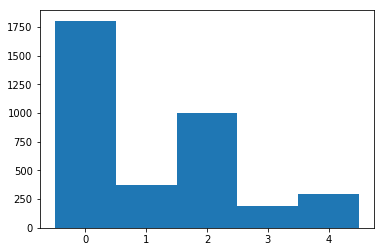

In [8]:
###plot the bar graph of the number of different classes
ll = [get_label(l) for l in labels]
plt.hist(ll, bins=np.arange(min(ll), max(ll)+2), align='left')

In [9]:
###This is a weight dictionary to give more weights to the less frequent classes,
###as there is an imbalanced dataset
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(ll),
                                                 ll)

In [10]:
class_weights

array([0.40576177, 1.97945946, 0.73313313, 3.79481865, 2.48271186])

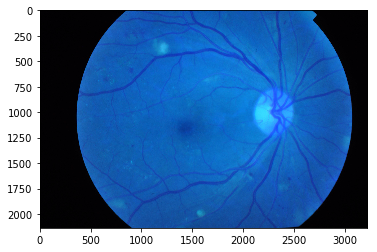

In [11]:
###Original image as given in the dataset.
plt.imshow(cv2.imread('../input/aptos2019-blindness-detection/train_images/4289af3afbd2.png'))

/opt/conda/lib/python3.6/site-packages/skimage/color/colorconv.py:265: RuntimeWarning: divide by zero encountered in true_divide
  out_s = delta / out_v
/opt/conda/lib/python3.6/site-packages/skimage/color/colorconv.py:271: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = (arr[idx, 1] - arr[idx, 2]) / delta[idx]
/opt/conda/lib/python3.6/site-packages/skimage/color/colorconv.py:275: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = 2. + (arr[idx, 2] - arr[idx, 0]) / delta[idx]
/opt/conda/lib/python3.6/site-packages/skimage/color/colorconv.py:279: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = 4. + (arr[idx, 0] - arr[idx, 1]) / delta[idx]
/opt/conda/lib/python3.6/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


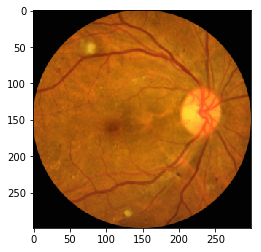

In [12]:
###Above image after all the preprocessing
plt.imshow((conv_clah(imread('../input/aptos2019-blindness-detection/train_images/4289af3afbd2.png'))), cmap ='gray')

**if you want oversampling run these cells below, but it didn't give any good results to me so i didnt use em**

In [13]:
###Don't run this cell if you want to reproduce my results.
#def get_data(kk, labels=labels, images=images):
#    labels1 = []
#    images1 = []
#    for i, j in zip(labels, images):
#        if get_label(i)==kk:
#            labels1.append(i)
#            images1.append(j)
#    return labels1, images1

#label_0, images_0 = get_data(0)
#label_1, images_1 = get_data(1)
#label_2, images_2 = get_data(2)
#label_3, images_3 = get_data(3)
#label_4, images_4 = get_data(4)

#max_size = max(len(label_0),len(label_1),len(label_2),len(label_3),len(label_4))

#labels_Y = []
#images_X = []
#labels_Y = label_0*( max_size//(len(label_0))) + label_1*( max_size//(len(label_1))) + label_2*( max_size//(len(label_2))) + label_3*( max_size//(len(label_3))) + label_4*( max_size//(len(label_4)))
#images_X = images_0*( max_size//(len(images_0))) + images_1*( max_size//(len(images_1))) + images_2*( max_size//(len(images_2))) + images_3*( max_size//(len(images_3))) + images_4*( max_size//(len(images_4)))

#labels_Y = labels_Y + label_1 + label_2[0:500]
#images_X =  images_X + images_1 + images_2[0:500]

#ll = [get_label(l) for l in labels_Y]
#plt.hist(ll, bins=np.arange(min(ll), max(ll)+3), align='left')

#images = images_X
#labels = labels_Y

In [14]:
###Using transfer learning cos I tried to make my own architecture and it didn't work,
####it was ridicilously overfitting and we need something readily available to us.
def inception_maker(img_dim, c ,n_class):
    input_tensor=Input(shape=(img_dim, img_dim,c))
  
    model = InceptionV3(weights=None, include_top=False, input_tensor=input_tensor)
    model.load_weights('../input/inception-weights/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')
    
    x=GlobalAveragePooling2D()(model.output)
    x=Dropout(0.3)(x)
    x=Dense(1024, activation='relu')(x)
    x=Dropout(0.2)(x)
    x=Dense(512, activation='relu')(x)
    x=Dropout(0.2)(x)
    x=BatchNormalization()(x)
    output =Dense(n_class,activation='softmax', name="Output_Layer")(x)
    model_inception =Model(input_tensor, output)
    
    return model_inception
model_inception=inception_maker(299,3, 5)

In [15]:
for layers in model_inception.layers:
    layers.trainable=True

In [16]:
lr = 0.005
optimizer=RMSprop(lr=lr,decay=0.1)
model_inception.compile(optimizer=optimizer, loss=keras.losses.categorical_crossentropy,  metrics=['accuracy'])

In [17]:
import gc
gc.collect()

353

In [18]:
df_train.id_code = df_train.id_code.apply(lambda x: x + ".png")
df_test.id_code = df_test.id_code.apply(lambda x: x + ".png")
df_train['diagnosis'] = df_train['diagnosis'].astype('str')

In [19]:
# Data Generator
train_datagen = image.ImageDataGenerator(rescale=None, preprocessing_function=conv_clah, validation_split=0.15, horizontal_flip=True,
                                         vertical_flip=True, rotation_range=360, zoom_range=0.2, shear_range=0.1)

In [20]:
train_generator = train_datagen.flow_from_dataframe(dataframe=df_train,
                                                    directory= '../input/aptos2019-blindness-detection/train_images/',
                                                    x_col='id_code',
                                                    y_col='diagnosis',
                                                    batch_size=8,
                                                    class_mode='categorical',
                                                    target_size=(299, 299),
                                                    subset='training',
                                                    shaffle=True,
                                                    seed=3
                                                    )
valid_generator = train_datagen.flow_from_dataframe(dataframe=df_train,
                                                    directory='../input/aptos2019-blindness-detection/train_images/',
                                                    x_col='id_code',
                                                    y_col='diagnosis',
                                                    batch_size=8,
                                                    class_mode='categorical',
                                                    target_size=(299, 299),
                                                    subset='validation',
                                                    shaffle=True,
                                                    seed=3
                                                    )
gc.collect()

Found 3113 validated image filenames belonging to 5 classes.
Found 549 validated image filenames belonging to 5 classes.


14

In [21]:
NUB_TRAIN_STEPS = train_generator.n // train_generator.batch_size
NUB_VALID_STEPS = valid_generator.n // valid_generator.batch_size

NUB_TRAIN_STEPS, NUB_VALID_STEPS

(389, 68)

In [22]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')
d_loss = model_inception.fit_generator(generator=train_generator,
                                     steps_per_epoch=NUB_TRAIN_STEPS,
                                     validation_data=valid_generator,
                                     validation_steps=NUB_VALID_STEPS,
                                     epochs=50,
                                     callbacks=[earlyStopping, reduce_lr_loss, mcp_save], class_weight=class_weights)
print(d_loss)
gc.collect()

/opt/conda/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Epoch 1/50


/opt/conda/lib/python3.6/site-packages/skimage/color/colorconv.py:265: RuntimeWarning: divide by zero encountered in true_divide
  out_s = delta / out_v
/opt/conda/lib/python3.6/site-packages/skimage/color/colorconv.py:271: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = (arr[idx, 1] - arr[idx, 2]) / delta[idx]
/opt/conda/lib/python3.6/site-packages/skimage/color/colorconv.py:275: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = 2. + (arr[idx, 2] - arr[idx, 0]) / delta[idx]
/opt/conda/lib/python3.6/site-packages/skimage/color/colorconv.py:279: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = 4. + (arr[idx, 0] - arr[idx, 1]) / delta[idx]
/opt/conda/lib/python3.6/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/conda/lib/python3.6/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision l

389/389 [==============================] - 798s 2s/step - loss: 1.3102 - acc: 0.5045 - val_loss: 1.2304 - val_acc: 0.5735
Epoch 2/50
389/389 [==============================] - 730s 2s/step - loss: 1.1066 - acc: 0.6044 - val_loss: 1.1444 - val_acc: 0.5952
Epoch 3/50
389/389 [==============================] - 738s 2s/step - loss: 1.0526 - acc: 0.6411 - val_loss: 0.9870 - val_acc: 0.6359
Epoch 4/50
389/389 [==============================] - 734s 2s/step - loss: 0.9960 - acc: 0.6587 - val_loss: 0.9080 - val_acc: 0.6728
Epoch 5/50
389/389 [==============================] - 735s 2s/step - loss: 0.9995 - acc: 0.6501 - val_loss: 0.8960 - val_acc: 0.6839
Epoch 6/50
389/389 [==============================] - 732s 2s/step - loss: 0.9877 - acc: 0.6587 - val_loss: 0.8763 - val_acc: 0.6895
Epoch 7/50
389/389 [==============================] - 738s 2s/step - loss: 0.9536 - acc: 0.6706 - val_loss: 0.8837 - val_acc: 0.6802
Epoch 8/50
389/389 [==============================] - 736s 2s/step - loss: 0.955

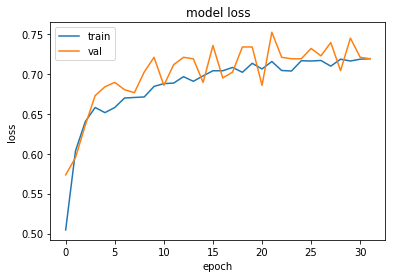

In [23]:
plt.plot(d_loss.history['acc'])
plt.plot(d_loss.history['val_acc'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [24]:
test_datagen = image.ImageDataGenerator(rescale=None, preprocessing_function=conv_clah, validation_split=0.2, horizontal_flip=True)

test_generator = test_datagen.flow_from_dataframe(dataframe=df_test,
                                                  directory= '../input/aptos2019-blindness-detection/test_images/',
                                                  x_col="id_code",
                                                  target_size=(299, 299),
                                                  batch_size=1,
                                                  shuffle=False,
                                                  class_mode=None,
                                                  seed=3)
print(df_test.shape[0])
gc.collect()

Found 1928 validated image filenames.
1928


2583

In [25]:
predictions = []
for i in tqdm(range(5)):
    test_generator.reset()
    preds = model_inception.predict_generator(generator=test_generator, steps=ceil(df_test.shape[0]))
    predictions.append(preds)
    
predictions = np.mean(predictions, axis=0)
predictions = np.argmax(predictions, axis=1)
len(predictions)

100%|██████████| 5/5 [19:33<00:00, 234.46s/it]


1928

In [26]:
results = pd.DataFrame({"id_code": test_generator.filenames, "diagnosis": predictions})
results.id_code = results.id_code.apply(lambda x: x[:-4])
results.to_csv("submission.csv", index=False)